In [1]:
from helper import *
from qpixl import *
import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import *
from qiskit_aer import StatevectorSimulator
import matplotlib.pyplot as plt

backend = StatevectorSimulator(method="statevector")


# Quantum Image Processing Project 
This notebook goes through an embedding known as the FRQI-QPIXL framework, which we have implemented in an easy to deploy set of modules for use in qiskit and pennylane  (Amankwah et al., May 2022, https://www.nature.com/articles/s41598-022-11024-y ). 
This are  included in the ```QPIXL_pennylane``` and ```QPIXL_qiskit``` folders. For the full version with compression there is a file called ```qpixl.py```, and  ```param_qpixl.py``` contains the parameterized version that can be used to generate a NISQ friendly feature map QML. For qiskit there can be no compression wwith the parameterized version, but pennylane can compress the parameterized version.

- Contents
    - Introduction
    - QPIXL
        - compression
        -  Photoshop
            - single image transforms
            - entangling multiple images
            - Animations
            - Simple RGB images
    - QML with QPIXL
        - Cancer Dataset with classical autoencoder preconditioning
        - Loading data
        - Defining QNN tree tensor network ansatz
        - Defining resnet18 autoencoder
        - running hybrid classical-quantum QNN

# Introduction

## Quantum killers for NISQ
The depth (and connectivity) of a circuit completely determines how well it can be implemented on existing hardware. The killing blow to most
algorithms is that they require fully connected and very deep circuits (which get decomposed to even deeper circuits with limited gatesets). 
Due to non-zero error rates, the probability that at least an error has occured throughout the run of a circuit eventually becomes 1. This can
be mitigated, but at some point it can't be done. This is why short circuits for flexible data embeddings are so important.

## Images in quantum computing
Although quantum computers have a more obvious to see advantage in quantum tasks, nonetheless it is thought that we can see some advantages in tasks involving
classical data loaded onto a quantum computer. Although pictures may not be 'the' data-type that will see an advantage from quantum computing, it is nonetheless 
the case that a lot of data can be input in an image-like format, and studying pictoral algorihtms is definitely way easier on the eyes than pure data-driven tasks! 
Also, with a quantum state representing an image, you can see the results of any quantum transformation of the picture as a new picture! Of course, it needs to be 
seen from many 'angles', but maybe it can help with visualizing what 

# QPIXL

Why do we need another type of embedding in the mix? QPIXL is a framework to decompose popular image encodings such as FRQI, NEQR and their improved counterparts. 
It works by optimally decomposing the gates, and removing any 0 angles that are found. Thanks to the optimal decomposition
the quantum gates can then be further reduced by removing pairs of CNOTS that used to be interweaved by rotation gates. 
They cancel out an become the identity. The code can be seen in the cell below:

In [2]:
def cFRQI(a, compression):
    """    Takes a standard image in a numpy array (so that the matrix looks like
    the image you want if you picture the pixels) and returns the QPIXL
    compressed FRQI circuit. The compression ratio determines
    how many gates will be filtered and then cancelled out. Made into code from this paper:
    https://www.nature.com/articles/s41598-022-11024-y

    Args:
        a (np.array): numpy array of image, must be flattened and padded with zeros up to a power of two
        compression (float): number between 0 an 100, where 0 is no compression and 100 is no image

    Returns:
        QuantumCircuit: qiskit circuit that prepared the encoded image
    """
    a = convertToAngles(a) # convert grayscale to angles
    a = preprocess_image(a) # need to flatten the transpose for easier decoding, 
                            # only really necessary if you want to recover an image.
                            # for classification tasks etc. transpose isn't required.
    n = len(a)
    k = ilog2(n)
    a = 2*a 
    a = sfwht(a)
    a = grayPermutation(a) 
    a_sort_ind = np.argsort(np.abs(a))
    # set smallest absolute values of a to zero according to compression param
    cutoff = int((compression / 100.0) * n)
    for it in a_sort_ind[:cutoff]:
        a[it] = 0
    # print(a)
    # Construct FRQI circuit
    circuit = QuantumCircuit(k + 1)
    # Hadamard register
    circuit.h(range(k))
    # Compressed uniformly controlled rotation register
    ctrl, pc, i = 0, 0, 0
    while i < (2**k):
        # Reset the parity check
        pc = int(0)
        # Add RY gate
        if a[i] != 0:
            circuit.ry(a[i], k)
        # Loop over sequence of consecutive zero angles to 
        # cancel out CNOTS (or rather, to not include them)
        if i == ((2**k) - 1):
            ctrl=0
        else:
            ctrl = grayCode(i) ^ grayCode(i+1)
            ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
        # Update parity check
        pc ^= (2**ctrl)
        i += 1
        while i < (2**k) and a[i] == 0:
            # Compute control qubit
            if i == ((2**k) - 1):
                ctrl=0
            else:
                ctrl = grayCode(i) ^ grayCode(i+1)
                ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
            # Update parity check
            pc ^= (2**ctrl)
            i += 1              
        for j in range(k):
            if (pc >> j)  &  1:
                circuit.cx(j, k)      
    return circuit.reverse_bits()


This can be used to encode and see images! But to do this, you need to use the function that encodes the image into a circuit.
The circuit looks deep, but it is only (number_of_pixels) deep, the encoding this is based on is (number_of_pixels)^2!!! Can you imagine? 

# Depth Compression

Still, it is very deep, so what the authors found out is that you can cutoff the angles under some treshold and still get some quality, which allows you to remove pairs of cnots and the rotation gates - and greatly reduce the circuit depth! 
An example of how this looks is below. For a simple image and a complex image.

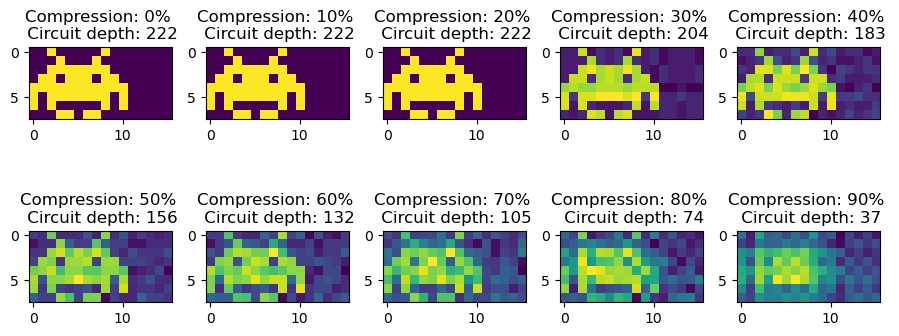

In [3]:
img = examples().space
shape = img.shape # save this for the reconstruction!

comp_images = []
labels = []
for i in range(0,110,10):
    comp_str = "Compression: "+str(i)+"% \n"
    qc = cFRQI(img,i)
    job = backend.run(qc)
    depth_str = " Circuit depth: "+str( qc.depth())
    #### Just for show
    sv = np.real(job.result().get_statevector())
    img2 = decodeQPIXL(sv)
    comp_images.append(reconstruct_img(img2, shape).T)
    labels.append(comp_str+depth_str)

fig = plt.figure(figsize=(9, 4))
columns = 5
rows = 2
for i in range(0, columns*rows ):
    img = comp_images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(labels[i])
plt.tight_layout()
plt.show()


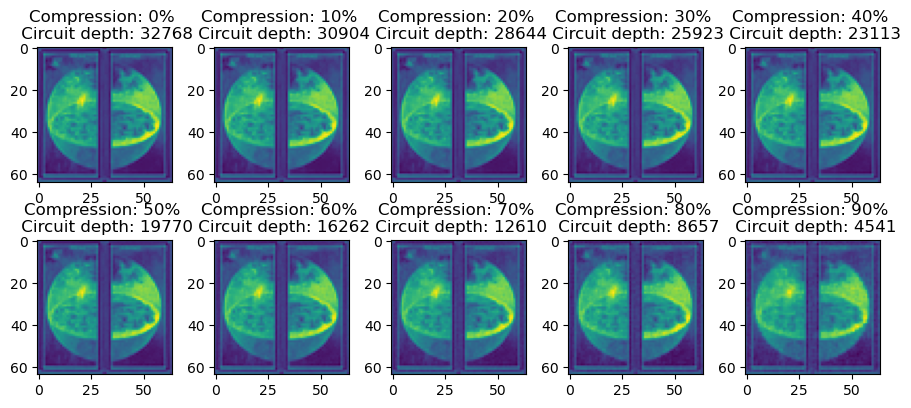

In [4]:
from PIL import Image

img = Image.open('figures/creation_world.png')
img = img.resize((64,64), Image.Resampling.LANCZOS)

shape = img.size
np_frame = np.array(img).T.flatten() #sometimes you have to transpose the image for the decoding to make sense
comp_images = []
labels = []
for i in range(0,100,10):
    comp_str = "Compression: "+str(i)+"% \n"
    qc = cFRQI(np_frame,i)
    job = backend.run(qc)
    depth_str = " Circuit depth: "+str( qc.depth())
    #### Just for show
    sv = np.real(job.result().get_statevector())
    img2 = decodeQPIXL(sv)
    comp_images.append(reconstruct_img(img2, shape))
    labels.append(comp_str+depth_str)

fig = plt.figure(figsize=(9, 4))
columns = 5
rows = 2
for i in range(0, columns*rows ):
    img = comp_images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(labels[i])
plt.tight_layout()
plt.show()

You can see that the quality for the high resolution image is much better than that of the low resolution image, but the fine details are lost all the same. 

# Quantum photoshop!
You can imagine that you can now do some quantum operation on this encoded state!!!
So what do a global rotation do to our image? Below are exampled for RX and RY rotations applied to each qubit.

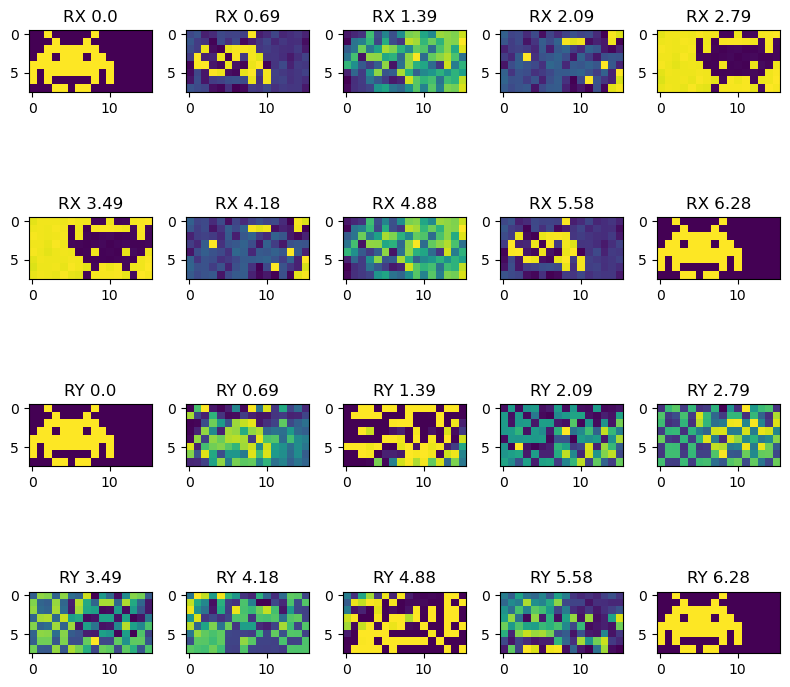

In [7]:
#### Single Picture 'Photoshop'
labels  = []
gen_mats = []
for i in np.linspace(0,2*np.pi,10):
    example = examples().space
    shape = example.shape
    qc = cFRQI(example,0)
    qc.rx(i,range(qc.num_qubits)) ### apply RX to everything
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, shape).T
    labels.append('RX '+str(i)[0:4])
    gen_mats.append(example)

for i in np.linspace(0,2*np.pi,10):
    example = examples().space
    qc = cFRQI(example,0)
    qc.ry(i,range(qc.num_qubits)) ### apply RY to everything
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, shape).T
    labels.append('RY '+str(i)[0:4])
    gen_mats.append(example)

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 4
for i in range(0, columns*rows ):
    img = gen_mats[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(labels[i])
plt.tight_layout()
plt.show()



Or you can imagine what happens applying it only to one qubit! Remeber that qubit 0 is the one that has all the CNOT targets and rotations.

In [3]:
from ipywidgets import interact
def plot_interactive_rot(ang, qubit, gate):
    example = examples().space
    qc = cFRQI(example,0)
    if gate == 'RY':
        qc.ry(ang,qubit) 
    if gate == 'RX':
        qc.rx(ang,qubit) ### apply RX to everything
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, examples().space.shape).T
    plt.imshow(example)

gates = ['RY','RX']
interact(plot_interactive_rot,ang=(0,np.pi,0.2),qubit=(0,7),gate=gates)


interactive(children=(FloatSlider(value=1.4000000000000001, description='ang', max=3.141592653589793, step=0.2…

<function __main__.plot_interactive_rot(ang, qubit, gate)>

In [5]:
def plot_interactive_cnot(control, target):
    example = examples().space
    qc = cFRQI(example,0)
    if control != target:
        qc.cx(control,target) ### apply RX to everything
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, examples().space.shape).T
    plt.imshow(example)

interact(plot_interactive_cnot,control=(0,7),target=(0,7))


interactive(children=(IntSlider(value=3, description='control', max=7), IntSlider(value=3, description='target…

<function __main__.plot_interactive_cnot(control, target)>

# Quantum entanglement of two images
Maybe you can explore the entanglement of two states if you only measure one of the two sates? We show an example of an image mixed with its own transpose by taking CNOTS betweent the two images, but perhaps there are other interesting approaches to take? 

In [25]:
img1 = Image.open('figures/creation_world.png')
img1 = img1.resize((64,64), Image.Resampling.LANCZOS)
shape1 = (64,64)
img2 = examples().space
shape2 = img.shape


img1 = convertToAngles(pad_0(img1))
img2 = convertToAngles(pad_0(img2))
qc1 = cFRQI(img1,0)
qc2 = cFRQI(img1.T,0)
big_qc = QuantumCircuit(qc1.width()+qc2.width())
big_qc = big_qc.compose(qc1, qubits=list(range(qc1.width())))
big_qc = big_qc.compose(qc2, qubits=list(range(qc1.width(),qc1.width()+qc2.width())))
### INSERT DESIRED GATES HERE
big_qc.x(range(qc1.width(),qc1.width()+qc2.width()))
for i in range(qc2.width()):
    big_qc.cnot(i, i+qc1.width())
    # Example of CNOT between two images
#########################
job = backend.run(big_qc)
sv = np.real(job.result().get_statevector())
img = decodeQPIXL(sv, state_to_prob = np.real)#Image 1 is the one that is recovered
img = reconstruct_img(img, shape1)


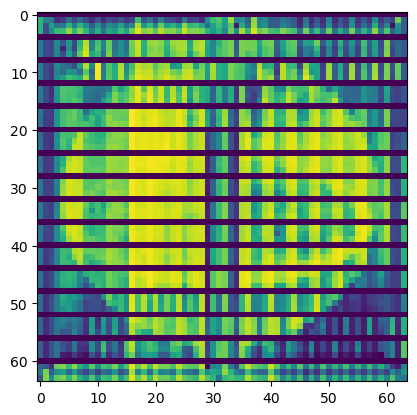

In [26]:
plt.imshow(img)

## Animations
You can even use it to make animations!

In [16]:
from matplotlib import animation

img = examples().space
shape = img.shape
def plot_interactive_rot(i):
    ang = i/300*2*np.pi
    example = examples().space
    qc = cFRQI(example,0)
    qc.ry(ang,range(qc.width())) 
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, shape).T
    plt.title('RY '+str(ang)[0:4])
    plt.imshow(example)

fig = plt.figure()
ani = animation.FuncAnimation(fig, plot_interactive_rot, interval=30,frames=300)
writergif = animation.PillowWriter(fps=60) 
ani.save('test_gif.gif', writer=writergif)


![SegmentLocal](figures/test_gif.gif "segment")

# Evolution from one image to another

How does an image transformation look in an embedding like qpixl? Well, we can interpolate between the angle embeddings of the two images and see! This is like an equation of motion for a ral system. 
We use two little aliens to illustrate how this would look like.


In [ ]:
alien1 = examples().space
shape1 = alien1.shape
alien2 = examples().invader
shape2 = alien2.shape


def plot_interactive_rot(i):
    t = 100*i/150
    example = ((100-t)/(100-1)) * alien1 + ((t-1)/(100-1)) * alien2
    qc = cFRQI(example,0)
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, shape1).T
    plt.title('transformation '+str(t)[0:4]+'%')
    plt.imshow(example)

fig = plt.figure()
ani = animation.FuncAnimation(fig, plot_interactive_rot, interval=30,frames=150)
writergif = animation.PillowWriter(fps=45) 
ani.save('transform.gif', writer=writergif)


![SegmentLocal](figures/transform.gif "segment")


In [10]:
def one_image_photoshop(backend, img,shape,comp=10, state_to_prob = np.real):
    """An example class for how you might do some 'quantum photshopping' with QPIXL

    Args:
        backend (qiskit quantum backend): A backend to simualte things, must output statevector or full probabilities
        img (np.array): array with image, can be flat or not
        shape (tuple): tuple with shape of image
        comp (int, optional): compress image, by what percentage. Defaults to 10.
        state_to_prob (function): how to cast your statevector to real values. Defaults to np.real.

    Returns:
        image: processed image
    """
    test = pad_0(img)
    test = convertToAngles(test)
    qc = cFRQI(test,10)
    ### INSERT DESIRED GATES HERE
    for i in range(1):
        qc.cnot(i,i+10)
    #################
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    img = decodeQPIXL(sv, state_to_prob = state_to_prob)
    img = reconstruct_img(img, shape)
    return img


def two_image_comb(backend, img1,img2,shape,comp=10,state_to_prob = np.abs):
    """An example class for how you might do some 'quantum photshopping' with QPIXL
    this can combine two images! You should change the gates in the playzone in the middle

    Args:
        backend (qiskit quantum backend): A backend to simualte things, must output statevector or full probabilities
        img1 (np.array): array with image 1, can be flat or not
        img2 (np.array): array with image 1, can be flat or not
        shape (tuple): tuple with shape of image
        comp (int, optional): compress image, by what percentage. Defaults to 10.
        state_to_prob (function): how to cast your statevector to real values. Defaults to np.real.

    Returns:
        image: processed image
    """

    img1 = convertToAngles(pad_0(img1))
    img2 = convertToAngles(pad_0(img2))
    qc1 = cFRQI(img1,comp)
    qc2 = cFRQI(img2,comp)
    big_qc = QuantumCircuit(qc1.width()+qc2.width())
    big_qc = big_qc.compose(qc1, qubits=list(range(qc1.width())))
    big_qc = big_qc.compose(qc2, qubits=list(range(qc1.width(),qc1.width()+qc2.width())))
    ### INSERT DESIRED GATES HERE
    big_qc.x(range(qc1.width(),qc1.width()+qc2.width()))
    for i in range(qc2.width()):
        big_qc.cnot(i, i+qc1.width())
        # Example of CNOT between two images
    #########################
    job = backend.run(big_qc)
    sv = np.real(job.result().get_statevector())
    img = decodeQPIXL(sv, state_to_prob = state_to_prob)#Image 1 is the one that is recovered
    img = reconstruct_img(img, shape)
    return img


# RGB QPXL!
You can of course, encode three different channels separately and recombine in post for cool effects, perhaps by rotating the different channels by different angles, we rotate the image by pi/10 for the green channel and pi/5 for the blue channel.


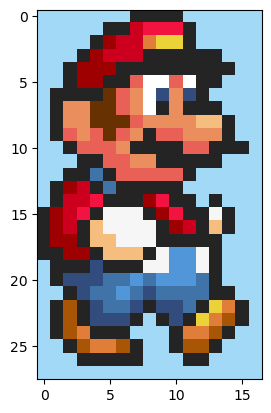

In [30]:
from PIL import Image
# READ IMAGE AND SPLIT
Image_ghost = Image.open('figures/mario_eg.png')
Image_ghost_data = np.asarray(Image_ghost)

red_channel = []
green_channel = []
blue_channel = []

for i in range(len(Image_ghost_data)):
    for j in range(len(Image_ghost_data[0])):
        red_channel.append(Image_ghost_data[i][j][0])

for i in range(len(Image_ghost_data)):
    for j in range(len(Image_ghost_data[0])):
        green_channel.append(Image_ghost_data[i][j][1])

for i in range(len(Image_ghost_data)):
    for j in range(len(Image_ghost_data[0])):
        blue_channel.append(Image_ghost_data[i][j][2])
        

red_channel = np.array(red_channel).reshape(len(Image_ghost_data), len(Image_ghost_data[0]))
green_channel = np.array(green_channel).reshape(len(Image_ghost_data), len(Image_ghost_data[0]))
blue_channel = np.array(blue_channel).reshape(len(Image_ghost_data), len(Image_ghost_data[0]))
chans = [red_channel, green_channel, blue_channel]
plt.imshow(Image_ghost)

## Ideal decoding

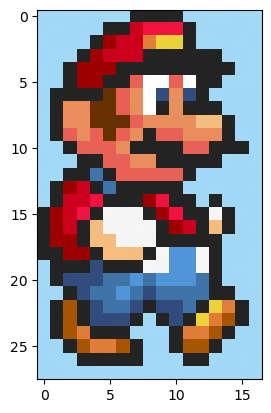

In [31]:
encoded_decoded = []
angs = [0,np.pi/10,np.pi/5]
for i, ang in zip(chans,angs):
    qc = cFRQI(i,0)
    job = backend.run(qc)
    #### Just for show
    sv = np.real(job.result().get_statevector())
    img2 = decodeQPIXL(sv)
    encoded_decoded.append(reconstruct_img(img2, (len(Image_ghost_data), len(Image_ghost_data[0]))))

rgb = np.dstack(encoded_decoded)
plt.imshow( Image.fromarray(np.array(rgb).astype(np.uint8), 'RGB'))

## With quantum effects

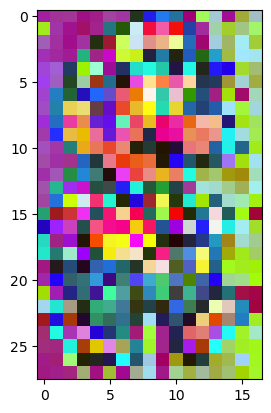

In [29]:
encoded_decoded = []
angs = [0,np.pi/10,np.pi/5]
for i, ang in zip(chans,angs):
    qc = cFRQI(i,0)
    qc.ry(ang,range(qc.width())) 

    job = backend.run(qc)
    #### Just for show
    sv = np.real(job.result().get_statevector())
    img2 = decodeQPIXL(sv)
    encoded_decoded.append(reconstruct_img(img2, (len(Image_ghost_data), len(Image_ghost_data[0]))))

rgb = np.dstack(encoded_decoded)
plt.imshow( Image.fromarray(np.array(rgb).astype(np.uint8), 'RGB'))

# SCIENCE

Of course, all is well and fun, and we can visualize some cool quantum operations on an 'inmage state', but obviously the main reason for these embeddings is not to make nice pictures, but to use them to encode data for tasks like classification for QML, or we can use image embedding to encode different types of data - linear depth is a pretty nice embedding ratio after-all! 

# QML with QPIXL embedding with classical autoencoder for image compression

So instead of using just a directly image loaded QML, we first pretrain a classical autoencoder and do a transfer learning approach. FOr this toy example we use a pretrained resnet18, but one could imagine refining model parameters to a dataset at the same time as the quantum weights! 

In [ ]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)
import param_qpixl_qml as pq
from qiskit.circuit import ParameterVector
# Plotting
import matplotlib.pyplot as plt
# SETUP
os.environ["OMP_NUM_THREADS"] = "8"
n_qubits = 11                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 100              # Number of samples for each training step
num_epochs = 30              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# LOAD DATA - INSPIRED BY PENNYLANE DEMO
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "cancer_classifier/Imagenes_Clasificadas_Random_Split/"
image_datasets = {
    x if x == "train" else "test": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "test"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "test"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "test"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
inputs, classes = next(iter(dataloaders["test"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "test"]
}
model_hybrid = torchvision.models.resnet18(pretrained=True)


Example of part of the dataset

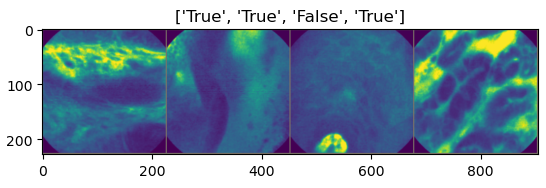

## QNN 
We use a tree tensor network ansatz to try and do the classification

In [ ]:
## QUANTUM NN
def block(weights, wires):
    qml.RX(weights[0], wires=wires[0])
    qml.RZ(weights[1], wires=wires[0])
    qml.RX(weights[2], wires=wires[1])
    qml.RZ(weights[3], wires=wires[1])
    qml.CNOT(wires=wires)
    
dev = qml.device("default.qubit", wires=n_qubits+5)
@qml.qnode(dev, interface="torch")
def quantum_net(input_feat,weights):
    quantum_input = pq.encode_image(input_feat)
    pq.param_qpixl(quantum_input) ## PENNYL:ANE QPIXL
    qml.TTN(wires=range(n_qubits+5),
            n_block_wires=2,
            block=block,
            n_params_block=4,
            template_weights=weights)
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in [14,15]]
    return tuple(exp_vals)
def costfunc(params):
    cost = 0
    for i in range(len(BAS)):
        if i < len(BAS) / 2:
            cost += circuit(BAS[i], params)
        else:
            cost -= circuit(BAS[i], params)
    return cost


## Hybrid QNN with classical autoencoder
We use a classical autoencoder to reduce the dimensions in such a way that the image highlights features we want to classify with the QNN, where the embedding is done with QPIXL and the trained weights affect the tensor network tree. Our loss is cross entropy, the preffered method for classification tasks

In [38]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, 32*32)
        self.q_params = nn.Parameter(q_delta * torch.randn((15,4)))
        self.post_net = nn.Linear(2, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, 2)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)


In [39]:
for param in model_hybrid.parameters():
    param.requires_grad = False
model_hybrid.fc = DressedQuantumNet()
model_hybrid = model_hybrid.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "test  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "test" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "test" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model


In [ ]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)


Training started:


/opt/conda/lib/python3.10/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


### Preliminary results
We were not able to fully train this system in time, but we had some promising preliminary results, reaching an accuracy of 70% on the testing data!
```
Training started:
Phase: train Epoch: 20/30 Loss: 0.6958 Acc: 0.6254      
Phase: test   Epoch: 20/30 Loss: 0.6296 Acc: 0.7099       
``` 


### Visualization

Now we can see how well our model does! 



In [ ]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
visualize_model(model_hybrid, num_images=batch_size)
plt.show()
